<a href="https://colab.research.google.com/github/lisaong/stackup-workshops/blob/fix-column-names/learn-history/learning_from_history.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learn from History 101: Demo Notebook

This notebook demonstrates:
- How to download a dataset from data.gov.sg
- How to formulate the dataset into a Machine Learning problem for Forecasting and train a simple Neural Network to predict the next value.
- How to formulate the same dataset into an ML problem for Pattern Recognition and train a different Neural Network to predict the pattern.

### Imports

All these libraries below are included in Google Colab. 
If you are running this from your local Python install, you can download requirements.txt from [here](https://github.com/lisaong/stackup-workshops/blob/master/learn-history/requirements.txt) and then do a `pip install -r requirements.txt`. 

Handy references:

- Pandas: https://pandas.pydata.org/Pandas_Cheat_Sheet.pdf
- Matplotlib: https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Python_Matplotlib_Cheat_Sheet.pdf
- Sklearn: https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Scikit_Learn_Cheat_Sheet_Python.pdf
- Statsmodels: https://www.statsmodels.org/stable/
- Tensorflow-Keras: https://www.tensorflow.org/guide/keras/overview


In [1]:
# visualisation
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# dataset downloading
import io
import requests
import zipfile

# data processing
import pandas as pd

# models
from sklearn.model_selection import train_test_split
import tensorflow as tf

# for saving the processed dataset
import pickle

plt.style.use('seaborn-whitegrid')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Download dataset

1. Browse to the data.gov.sg dataset page, e.g. https://data.gov.sg/dataset/gross-domestic-product-in-chained-2015-dollars-year-on-year-growth-rate-quarterly

2. Find the "Download dataset button"

3. Right-click and copy the link (which should point to a .zip file), e.g. https://data.gov.sg/dataset/92bcfcdf-cbb2-4497-a855-5aad9cf95cad/download

4. Paste the link in `DATASET_URL` below.

In [0]:
# https://data.gov.sg/dataset/gross-domestic-product-in-chained-2015-dollars-year-on-year-growth-rate-quarterly
DATASET_URL = 'https://data.gov.sg/dataset/92bcfcdf-cbb2-4497-a855-5aad9cf95cad/download'

headers = {
    'User-Agent': 'Mozilla/5.0',
}
response = requests.get(DATASET_URL, headers=headers)
z = zipfile.ZipFile(io.BytesIO(response.content))
z.extractall()

In [3]:
# get the filename
z.printdir()

File Name                                             Modified             Size
metadata-gross-domestic-product-in-chained-2015-dollars-year-on-year-growth-rate-quarterly.txt 2020-06-05 05:23:40         2520
gross-domestic-product-in-chained-2015-dollars-year-on-year-growth-rate-quarterly.csv 2020-06-05 05:23:40         7647


Update `CSV_FILE` to use the correct .csv filename. Some zip files contain multiple datasets.

In [4]:
# Note: update CSV_FILE to the .csv filename from above
CSV_FILE = 'gross-domestic-product-in-chained-2015-dollars-year-on-year-growth-rate-quarterly.csv'

df = pd.read_csv(CSV_FILE, parse_dates=True, index_col=0)
df.head()

,level_1,value
quarter,,
1976-01-01,GDP In Chained (2015) Dollars,8.2
1976-04-01,GDP In Chained (2015) Dollars,7.4
1976-07-01,GDP In Chained (2015) Dollars,7.2
1976-10-01,GDP In Chained (2015) Dollars,7.0
1977-01-01,GDP In Chained (2015) Dollars,6.2


# Data Exploration

1. Plot the dataset
2. Compute the min, max, etc
3. Plot the autocorrelation

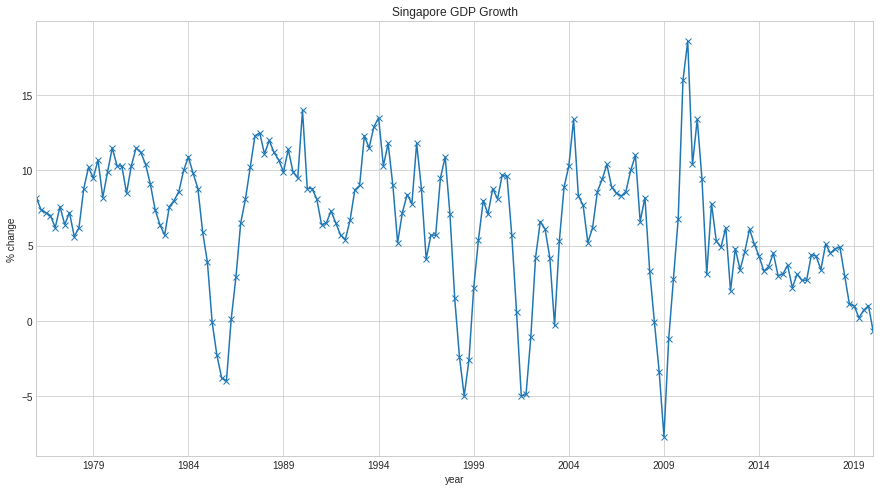

In [5]:
df['value'].plot(figsize=(15, 8), marker='x', title='Singapore GDP Growth')
plt.xlabel('year')
plt.ylabel('% change')
plt.show()

In [6]:
df['value'].describe()

count    177.000000
mean       6.450282
std        4.367833
min       -7.700000
25%        4.200000
50%        7.100000
75%        9.500000
max       18.600000
Name: value, dtype: float64

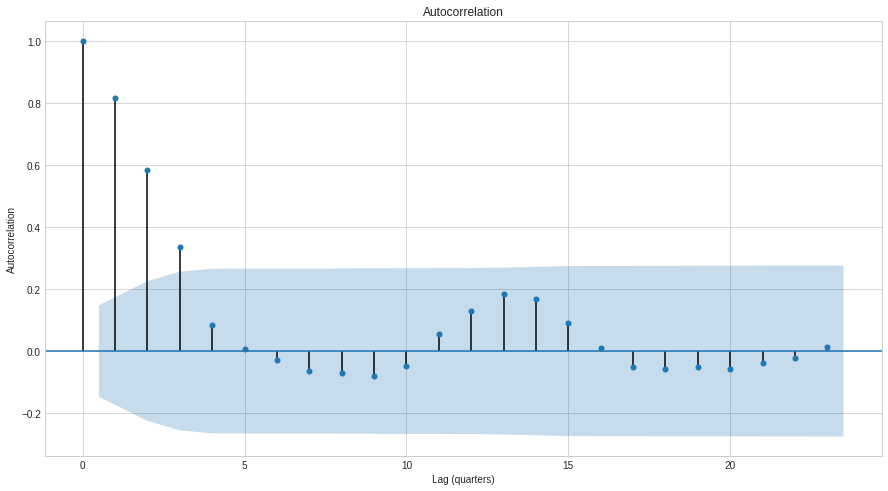

In [7]:
fig, ax = plt.subplots(figsize=(15, 8))
plot_acf(df['value'], ax=ax)
ax.set_ylabel('Autocorrelation')
ax.set_xlabel('Lag (quarters)')
plt.show()

In [0]:
window_size = 3 # largest number of lags above the 95% confidence band

# Windowing

1. Create shifted windows of the dataset.
2. Use this to setup our inputs and target.

In [9]:
# original dataset
df['value']

quarter
1976-01-01    8.2
1976-04-01    7.4
1976-07-01    7.2
1976-10-01    7.0
1977-01-01    6.2
             ... 
2019-01-01    1.0
2019-04-01    0.2
2019-07-01    0.7
2019-10-01    1.0
2020-01-01   -0.7
Name: value, Length: 177, dtype: float64

In [10]:
# shift up 1 step in time using -1
# (note the quarter index does not change, we'll fix that later)
df['value'].shift(-1)

quarter
1976-01-01    7.4
1976-04-01    7.2
1976-07-01    7.0
1976-10-01    6.2
1977-01-01    7.6
             ... 
2019-01-01    0.2
2019-04-01    0.7
2019-07-01    1.0
2019-10-01   -0.7
2020-01-01    NaN
Name: value, Length: 177, dtype: float64

In [11]:
# shift up in time using -2
# (note the quarter index does not change, we'll fix that later)
df['value'].shift(-2)

quarter
1976-01-01    7.2
1976-04-01    7.0
1976-07-01    6.2
1976-10-01    7.6
1977-01-01    6.4
             ... 
2019-01-01    0.7
2019-04-01    1.0
2019-07-01   -0.7
2019-10-01    NaN
2020-01-01    NaN
Name: value, Length: 177, dtype: float64

In [12]:
# column-wise concatenation

# List comprehension, equivalent to:
# new_columns = []
# for i in range(window_size):
#    new_columns.append(df['value'].shift(-i))
new_columns = [df['value'].shift(-i) for i in range(window_size+1)]
new_column_names = [f't+{i}' for i in range(window_size+1)]

df_windowed = pd.concat(new_columns, axis=1)
df_windowed.columns = new_column_names
df_windowed

,t+0,t+1,t+2,t+3
quarter,,,,
1976-01-01,8.2,7.4,7.2,7.0
1976-04-01,7.4,7.2,7.0,6.2
1976-07-01,7.2,7.0,6.2,7.6
1976-10-01,7.0,6.2,7.6,6.4
1977-01-01,6.2,7.6,6.4,7.2
...,...,...,...,...
2019-01-01,1.0,0.2,0.7,1.0
2019-04-01,0.2,0.7,1.0,-0.7
2019-07-01,0.7,1.0,-0.7,NaN


In [13]:
# cleanup the NaN at the bottom of the dataset
df_windowed.dropna(inplace=True)
df_windowed

,t+0,t+1,t+2,t+3
quarter,,,,
1976-01-01,8.2,7.4,7.2,7.0
1976-04-01,7.4,7.2,7.0,6.2
1976-07-01,7.2,7.0,6.2,7.6
1976-10-01,7.0,6.2,7.6,6.4
1977-01-01,6.2,7.6,6.4,7.2
...,...,...,...,...
2018-04-01,4.9,3.0,1.1,1.0
2018-07-01,3.0,1.1,1.0,0.2
2018-10-01,1.1,1.0,0.2,0.7


In [14]:
# Formulate our problem

df_windowed.columns

Index(['t+0', 't+1', 't+2', 't+3'], dtype='object')

In [15]:
# the target we want to predict (lowercase y is a convention for a vector)
y = df_windowed['t+3']

# the input data (uppercase X is a convention for a matrix)
X = df_windowed.drop(columns=['t+3'])

X.shape, y.shape

((174, 3), (174,))

# Neural Network

1. Create a neural network using Tensorflow-Keras
2. Split the dataset into training and test sets
3. Train the neural network using the training set.
4. Evaluate the neural network using the test set.

## Architecture
![neural network](https://github.com/lisaong/stackup-workshops/raw/master/learn-history/Neural%20Network.png)

In [18]:
# https://www.tensorflow.org/guide/keras/overview
# Create a simple Neural Network with 2 Dense Layers
from tensorflow.keras import layers

model = tf.keras.Sequential()
model.add(layers.Dense(16, input_shape=(3,), activation='relu'))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 16)                64        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 81
Trainable params: 81
Non-trainable params: 0
_________________________________________________________________


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((130, 3), (44, 3), (130,), (44,))

In [20]:
# Note that the data is shuffled in time
# This is okay because we already preserved the history!
#
# If this bothers you, you can use train_test_split(X, y, shuffle=False)
# It does affect how the Neural Network is initialised, but since we
# will be go through the dataset multiple rounds, it doesn't really matter.
#
# It may matter if your dataset is huge, because the Neural Network training
# gets more chances see the older data. 
X_train

,t+0,t+1,t+2
quarter,,,
2001-01-01,5.7,0.6,-5.0
1993-10-01,12.9,13.5,10.3
2012-07-01,2.0,4.8,3.4
2017-07-01,5.1,4.5,4.8
1981-07-01,11.2,10.4,9.1
...,...,...,...
2011-04-01,3.1,7.8,5.3
1995-01-01,5.2,7.2,8.4
2014-01-01,4.3,3.3,3.6


In [21]:
# What matters is that each row of X_train and each row of y_train
# are for the same quarter!
y_train

quarter
2001-01-01    -4.9
1993-10-01    11.8
2012-07-01     4.6
2017-07-01     4.9
1981-07-01     7.4
              ... 
2011-04-01     4.9
1995-01-01     7.8
2014-01-01     4.5
1995-04-01    11.8
1976-01-01     7.0
Name: t+3, Length: 130, dtype: float64

In [22]:
# train!
# Note: if you have more data, you can split the dataset 3 ways:
#  train, validation, test
# And then use the validation set (e.g. X_val, y_val) in validation_data

model.compile(optimizer='Adam', loss='mse', metrics=['mae'])
history = model.fit(X_train, y_train, batch_size=16, epochs=50,
                    validation_data=(X_test, y_test))

Epoch 1/50
9/9 [==============================] - 0s 22ms/step - loss: 65.7288 - mae: 7.1357 - val_loss: 61.4041 - val_mae: 6.9648
Epoch 2/50
9/9 [==============================] - 0s 7ms/step - loss: 61.3210 - mae: 6.8729 - val_loss: 56.5992 - val_mae: 6.6577
Epoch 3/50
9/9 [==============================] - 0s 7ms/step - loss: 57.2045 - mae: 6.6260 - val_loss: 52.5073 - val_mae: 6.3832
Epoch 4/50
9/9 [==============================] - 0s 6ms/step - loss: 53.6662 - mae: 6.4017 - val_loss: 48.9606 - val_mae: 6.1356
Epoch 5/50
9/9 [==============================] - 0s 7ms/step - loss: 50.3260 - mae: 6.1892 - val_loss: 45.7771 - val_mae: 5.9136
Epoch 6/50
9/9 [==============================] - 0s 6ms/step - loss: 47.6462 - mae: 6.0076 - val_loss: 42.8360 - val_mae: 5.7015
Epoch 7/50
9/9 [==============================] - 0s 6ms/step - loss: 45.0344 - mae: 5.8307 - val_loss: 40.4304 - val_mae: 5.5221
Epoch 8/50
9/9 [==============================] - 0s 6ms/step - loss: 42.9088 - mae: 5.67

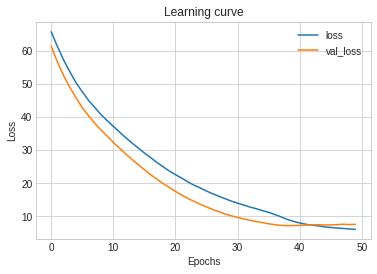

In [23]:
# Check for overfitting, which is when val_loss starts to go up but
# loss stays decreases or stays constant.

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Learning curve')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [0]:
model.save('model.h5')

In [25]:
# Get a prediction from our model for our data and plot it against the truth

y_pred = model.predict(X)

df_pred = pd.DataFrame(index=X.index, data={'predictions': y_pred.ravel()})
df_pred

,predictions
quarter,
1976-01-01,7.142591
1976-04-01,6.983024
1976-07-01,6.090951
1976-10-01,7.819475
1977-01-01,6.221447
...,...
2018-04-01,1.369195
2018-07-01,1.313666
2018-10-01,0.621045


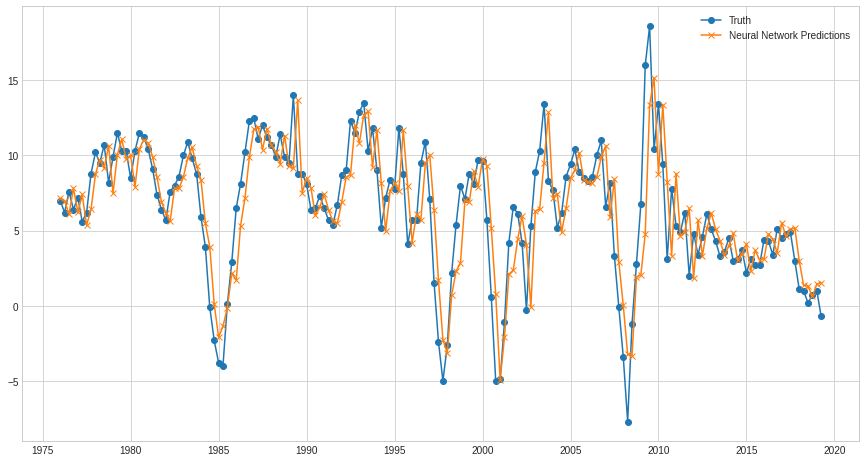

In [26]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(y, label='Truth', marker='o')
ax.plot(df_pred, label='Neural Network Predictions', marker='x')
ax.legend()
plt.show()

## Further experimentations:

- A larger or smaller `window_size` and see how it affects the result. For a larger `window_size`, you should observe that the smoothing effect increases.

- More or fewer neurons in the Neural Network. When more neurons are used, you should observe that the training error will be lower, but the validation error will start to rise (overfitting).

- More or fewer layers in the Neural Network. Similar effect as the number of neurons. More layers will tend to overfit.

## Further enhancements to the training process:
- Adding early stopping to stop the training once we observe that the validation error is rising (known as Overfitting)
- Add Tensorboard to observe the training progress in real time, instead of waiting for training to complete.
- Add automatic saving of the model at the lowest validation loss.

More details are at: https://www.tensorflow.org/guide/keras/overview#callbacks

## What about a Pattern Recognition problem?

A pattern recognition problem (i.e. a Classification problem) will require a different target column.

Instead of the t+3 value, we will need to somehow label the windows as showing a particular pattern. This is usually a custom process.

Reminder that you won't be using Auto-correlation here. Because auto-correlation is for predicting future values. 

Let's say we want to recognise periods of large GDP dips indicating a recession.


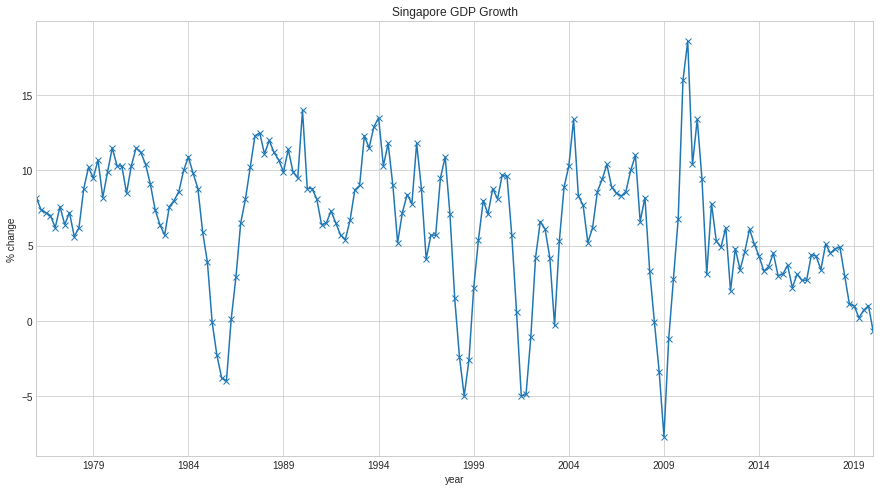

In [27]:
df['value'].plot(figsize=(15, 8), marker='x', title='Singapore GDP Growth')
plt.xlabel('year')
plt.ylabel('% change')
plt.show()

From the plot above, we can see that the values that fall signficantly tend to represent a dip.

So mathematically speaking, large positive and negative changes in the first derivative. 
* You can approximate the first derivative by taking the difference of the dataset
* However, note that this is specific to the type of pattern you want to find. Most of the time, it is custom labeled because the pattern can be different.
* Another option is to use clustering to do some unsupervised grouping, then use the clusters as labels.


In [28]:
df['value'].diff(15)

quarter
1976-01-01    NaN
1976-04-01    NaN
1976-07-01    NaN
1976-10-01    NaN
1977-01-01    NaN
             ... 
2019-01-01   -2.1
2019-04-01   -3.5
2019-07-01   -1.5
2019-10-01   -2.1
2020-01-01   -3.4
Name: value, Length: 177, dtype: float64

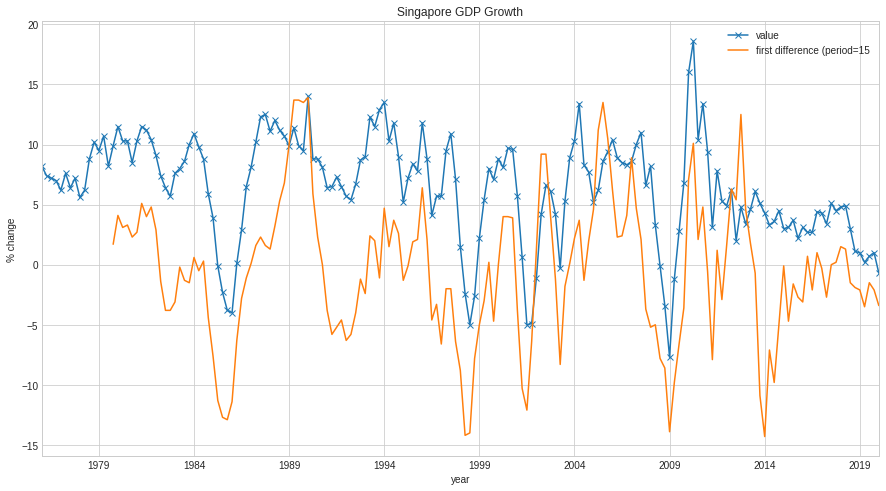

In [29]:
df['value'].plot(figsize=(15, 8), marker='x', title='Singapore GDP Growth')
df['value'].diff(15).plot(label='first difference (period=15')
plt.xlabel('year')
plt.ylabel('% change')
plt.legend()
plt.show()

In [30]:
# Based on looking at the df plot, a recession usually lasts about 15 quarters
# (a larger window will also make the label less sensitive to noise)
dip_window_size = 15 

new_columns_dip = [df['value'].shift(-i) for i in range(dip_window_size+1)]
new_column_names = [f't+{i}' for i in range(dip_window_size+1)]

df_pattern = pd.concat(new_columns_dip, axis=1)
df_pattern.columns = new_column_names
df_pattern['recession'] = df['value'].diff(dip_window_size) <= -5 # arbitrary

df_pattern.dropna(inplace=True)
df_pattern

,t+0,t+1,t+2,t+3,t+4,t+5,t+6,t+7,t+8,t+9,t+10,t+11,t+12,t+13,t+14,t+15,recession
quarter,,,,,,,,,,,,,,,,,
1976-01-01,8.2,7.4,7.2,7.0,6.2,7.6,6.4,7.2,5.6,6.2,8.8,10.2,9.5,10.7,8.2,9.9,False
1976-04-01,7.4,7.2,7.0,6.2,7.6,6.4,7.2,5.6,6.2,8.8,10.2,9.5,10.7,8.2,9.9,11.5,False
1976-07-01,7.2,7.0,6.2,7.6,6.4,7.2,5.6,6.2,8.8,10.2,9.5,10.7,8.2,9.9,11.5,10.3,False
1976-10-01,7.0,6.2,7.6,6.4,7.2,5.6,6.2,8.8,10.2,9.5,10.7,8.2,9.9,11.5,10.3,10.3,False
1977-01-01,6.2,7.6,6.4,7.2,5.6,6.2,8.8,10.2,9.5,10.7,8.2,9.9,11.5,10.3,10.3,8.5,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-04-01,3.1,3.7,2.2,3.1,2.7,2.7,4.4,4.3,3.4,5.1,4.5,4.8,4.9,3.0,1.1,1.0,False
2015-07-01,3.7,2.2,3.1,2.7,2.7,4.4,4.3,3.4,5.1,4.5,4.8,4.9,3.0,1.1,1.0,0.2,False
2015-10-01,2.2,3.1,2.7,2.7,4.4,4.3,3.4,5.1,4.5,4.8,4.9,3.0,1.1,1.0,0.2,0.7,False


KeyError: ignored

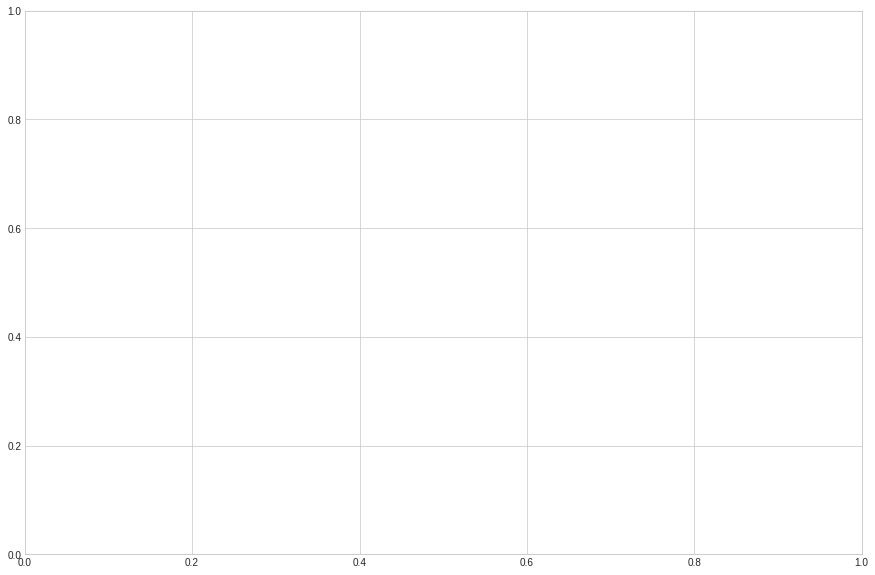

In [31]:
# plot the 'recession' target indicator with the series
recession_mask = df_pattern['recession'] == True

fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(df_pattern['t-0'], label='series')
ax.scatter(df_pattern[recession_mask].index,
            df_pattern[recession_mask]['t-0'],
            label='recession', marker='x', color='red')
ax.set_xlabel('year')
ax.set_ylabel('% change')
ax.legend()
plt.show()

It's close, but not perfect. Labeling data is both an art and a science, and also expensive to do.

In [32]:
# To complete the demo
y = df_pattern['recession'] # now this is a discrete value
X = df_pattern.drop(columns=['recession'])

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

# Let's try the same model as before, with 1 change to the output
# sigmoid will restrict the output between the range of 0 and 1
# rather than let it be any number
model_pattern = tf.keras.Sequential()
model_pattern.add(layers.Dense(16, input_shape=(X_train.shape[1],),
                               activation='relu'))
model_pattern.add(layers.Dense(1, activation='sigmoid'))
model_pattern.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 289
Trainable params: 289
Non-trainable params: 0
_________________________________________________________________


Epoch 1/50
8/8 [==============================] - 0s 19ms/step - loss: 1.5853 - accuracy: 0.7273 - val_loss: 0.9833 - val_accuracy: 0.7805
Epoch 2/50
8/8 [==============================] - 0s 10ms/step - loss: 1.3571 - accuracy: 0.7273 - val_loss: 0.8299 - val_accuracy: 0.7805
Epoch 3/50
8/8 [==============================] - 0s 10ms/step - loss: 1.1577 - accuracy: 0.7355 - val_loss: 0.7066 - val_accuracy: 0.7805
Epoch 4/50
8/8 [==============================] - 0s 10ms/step - loss: 0.9758 - accuracy: 0.7521 - val_loss: 0.6090 - val_accuracy: 0.8293
Epoch 5/50
8/8 [==============================] - 0s 9ms/step - loss: 0.8063 - accuracy: 0.7603 - val_loss: 0.5246 - val_accuracy: 0.8293
Epoch 6/50
8/8 [==============================] - 0s 11ms/step - loss: 0.6593 - accuracy: 0.7603 - val_loss: 0.4611 - val_accuracy: 0.8293
Epoch 7/50
8/8 [==============================] - 0s 10ms/step - loss: 0.5448 - accuracy: 0.7686 - val_loss: 0.4208 - val_accuracy: 0.8537
Epoch 8/50
8/8 [============

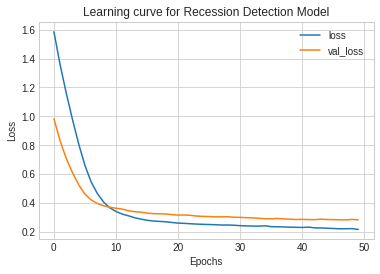

In [33]:
model_pattern.compile(optimizer='Adam', loss='binary_crossentropy',
                      metrics=['accuracy']) # different metrics and loss

history = model_pattern.fit(X_train, y_train, batch_size=16, epochs=50,
                           validation_data=(X_test, y_test))

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Learning curve for Recession Detection Model')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

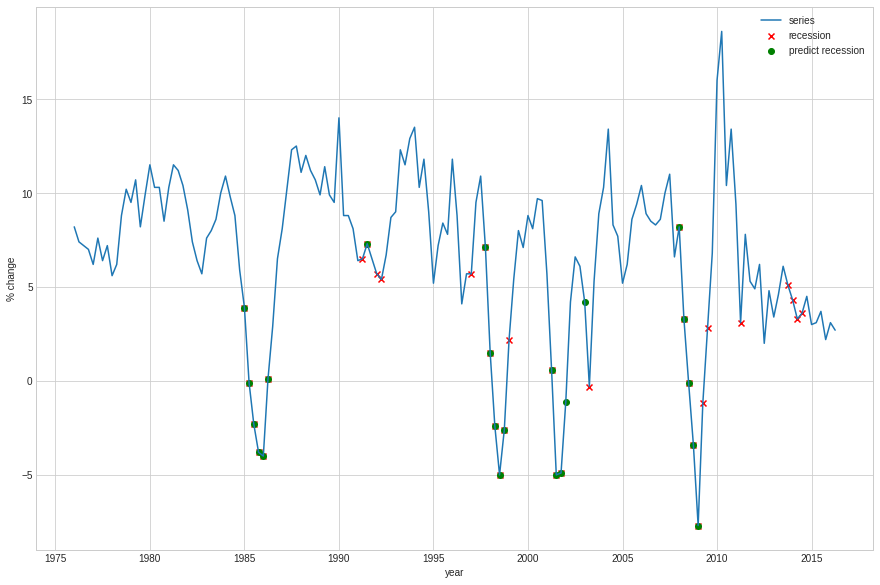

In [34]:
# plot the 'recession' prediction vs target

# predict will output probabilities, so we set a threshold of >=0.5
# to be "predict recession"
y_pred = model_pattern.predict(X) >= 0.5

recession_mask = df_pattern['recession'] == True
prediction_mask = y_pred == True

fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(df_pattern['t+0'], label='series')
ax.scatter(df_pattern[recession_mask].index,
            df_pattern[recession_mask]['t+0'],
            label='recession', marker='x', color='red')

ax.scatter(df_pattern[prediction_mask].index,
            df_pattern[prediction_mask]['t+0'],
            label='predict recession', marker='o', color='green')

ax.set_xlabel('year')
ax.set_ylabel('% change')
ax.legend()
plt.show()

In [0]:
model_pattern.save('model_pattern.h5')

# Continous Integration (Optional)

When Github workflow is enabled in the repository, changes to this notebook that are pushed to Github will trigger a test run. 

The test will load the models and compute the error metrics.

See:
https://github.com/lisaong/stackup-workshops/tree/master/.github/workflows

In [0]:
# Continuous integration is enabled on this notebook
# store artifacts for CI testing

ci_artifacts = {
    'df' : df,
    'df_windowed' : df_windowed,
    'df_pattern' : df_pattern,

    # save the filename, actual file will be picked up by the workflow
    'model_filename' : 'model.h5',

    # save the filename, actual file will be picked up by the workflow
    'model_pattern_filename' : 'model_pattern.h5'
}

pickle.dump(ci_artifacts, open('ci_artifacts.pkl', 'wb'))